In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone

from google.colab import files

# Dataset description:
Main link: https://archive.ics.uci.edu/ml/datasets/Air+Quality#
Data Set Information:
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.
Attribute Information:
0 Date (DD/MM/YYYY)
1 Time (HH.MM.SS)
2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7 True hourly averaged NOx concentration in ppb (reference analyzer)
8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12 Temperature in  °C
13 Relative Humidity (%)
14 AH Absolute Humidity




Relevant Papers:
S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia, On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario, Sensors and Actuators B: Chemical, Volume 129, Issue 2, 22 February 2008, Pages 750-757, ISSN 0925-4005, 

Saverio De Vito, Marco Piga, Luca Martinotto, Girolamo Di Francia, CO, NO2 and NOx urban pollution monitoring with on-field calibrated electronic nose by automatic bayesian regularization, Sensors and Actuators B: Chemical, Volume 143, Issue 1, 4 December 2009, Pages 182-191, ISSN 0925-4005, 

S. De Vito, G. Fattoruso, M. Pardo, F. Tortorella and G. Di Francia, 'Semi-Supervised Learning Techniques in Artificial Olfaction: A Novel Approach to Classification Problems and Drift Counteraction,' in IEEE Sensors Journal, vol. 12, no. 11, pp. 3215-3224, Nov. 2012.
doi: 10.1109/JSEN.2012.2192425



In [ ]:
uploaded = files.upload()

Saving AirQualityUCI.csv to AirQualityUCI (2).csv


# Data Preparation / EDA

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['AirQualityUCI.csv']), header=0, delimiter = ';', parse_dates =[['Date', 'Time']] )

In [ ]:
df.head()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004 18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004 19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004 20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004 21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004 22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [ ]:
df.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,NaN,NaN
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,NaN,NaN
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,NaN,NaN
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,NaN,NaN
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,NaN,NaN


In [ ]:
df.drop(columns = ['Unnamed: 15', 'Unnamed: 16'], inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date_Time      9471 non-null   object 
 1   CO(GT)         9357 non-null   object 
 2   PT08.S1(CO)    9357 non-null   float64
 3   NMHC(GT)       9357 non-null   float64
 4   C6H6(GT)       9357 non-null   object 
 5   PT08.S2(NMHC)  9357 non-null   float64
 6   NOx(GT)        9357 non-null   float64
 7   PT08.S3(NOx)   9357 non-null   float64
 8   NO2(GT)        9357 non-null   float64
 9   PT08.S4(NO2)   9357 non-null   float64
 10  PT08.S5(O3)    9357 non-null   float64
 11  T              9357 non-null   object 
 12  RH             9357 non-null   object 
 13  AH             9357 non-null   object 
dtypes: float64(8), object(6)
memory usage: 1.0+ MB


In [ ]:
df.index = df.Date_Time
df.drop(['Date_Time'],axis=1,inplace=True)

Some columns with numerical values are stored as objects. Seems commas are the problem here. Let's fix that

In [ ]:
for i in ['CO(GT)' , 'C6H6(GT)' , 'T' , 'RH' , 'AH']:
    df[i] = df[i].str.replace(',','.')
    df[i] = df[i].astype(float)

In [ ]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
10/03/2004 18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
10/03/2004 19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
10/03/2004 20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
10/03/2004 21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
10/03/2004 22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
df.isnull().sum()

CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
dtype: int64

there's 114 rows with empty values in each column. It's quite likely that all these are same rows, let's check that

In [ ]:
df.isnull().all(axis=1).sum()

114

Yep, these row can safely be dropped

In [ ]:
df = df.dropna()

We know that missing values are marked with -200. Let's check how many are there and in which columns

In [ ]:
df.eq(-200).sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [ ]:
df.replace(to_replace=-200,value=np.nan,inplace=True)

Looks like True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) are missing in most cases. There's also quite a bit of NOx and NO2 measurements missing from the reference analyzer

Let's check if there is a pattern at which data is missing

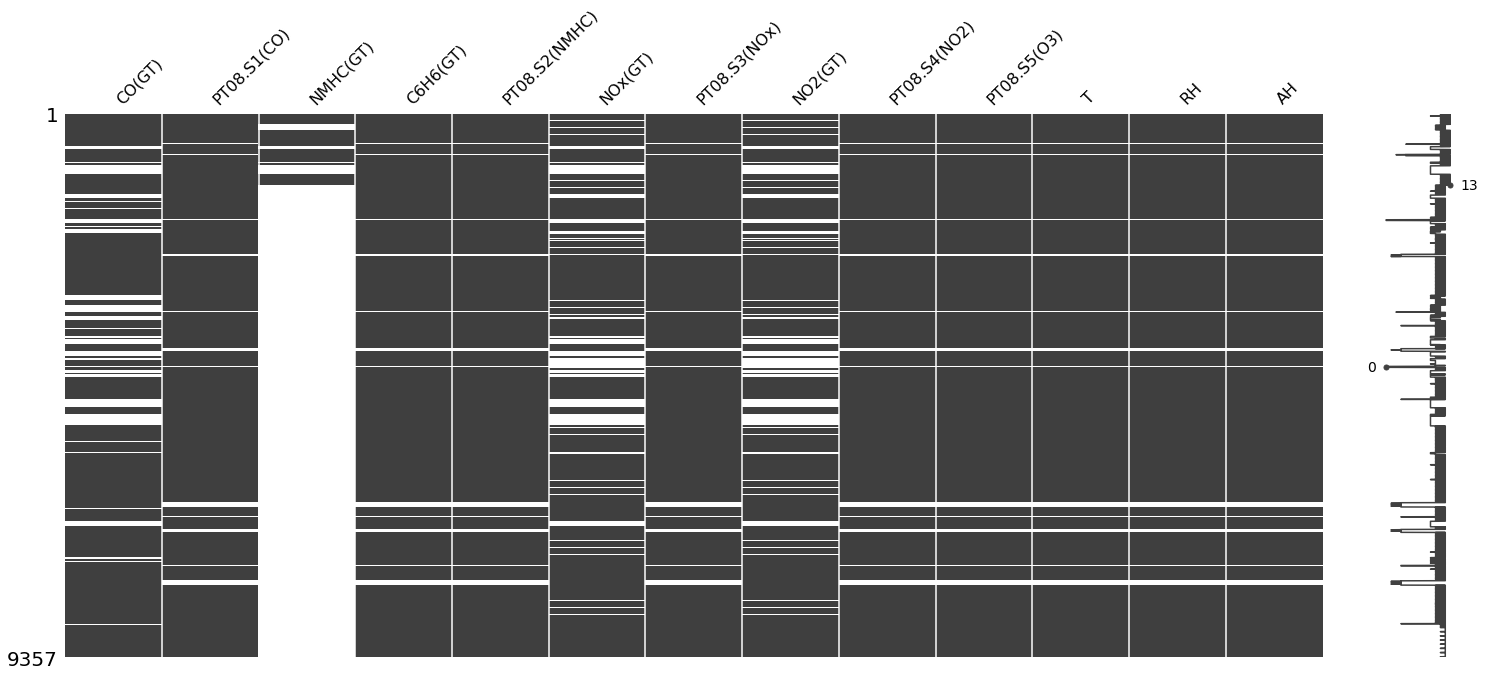

In [ ]:
msno.matrix(df)

Clearly NMHC(GT) sensor has stopped working shortly after the experiment has began. I'll conduct a few more checks but this column in my opinion will only introduce bias to the model and should be dropped.
The rest of the data seems to be missing in two patterns. The CO, NOx and PT08.S3.

This suggests the data is not missing totally at random. Might be a power outages in different bundles of sensors or some greater environmental issues for all we know. Seems that more data is missing from the reference analyzers than from the experimental sensors too.

In [ ]:
df['NMHC(GT)'].isna().sum() / len(df['NMHC(GT)'])

0.9023191193758683

In [ ]:
df['NMHC(GT)'].corr(df['C6H6(GT)'])

0.902559324353826

over 90% of NMHC values are missing. This feature will be dropped because it's too sparse to impute. It's safe to assume that the measurements were stopped for some reason or another. At the same time it correlates really strongly with C6H6 which is unsurprising because Benzene is one of the most common non metallic hydrocarbons. It should work well enough for capturing any influence of the NMHC on the model in general. Dropping the other missing values Before inputing data let's take a look at correlation matrix.

In [ ]:
fig = px.imshow(df.corr(), text_auto=True, color_continuous_scale='RdBu_r', title="Correlation Matrix", height = 1000, width = 1000)
fig.show()

In [ ]:
df.drop(['NMHC(GT)'],axis=1,inplace=True)

Let's see distributions of the remaining variables together

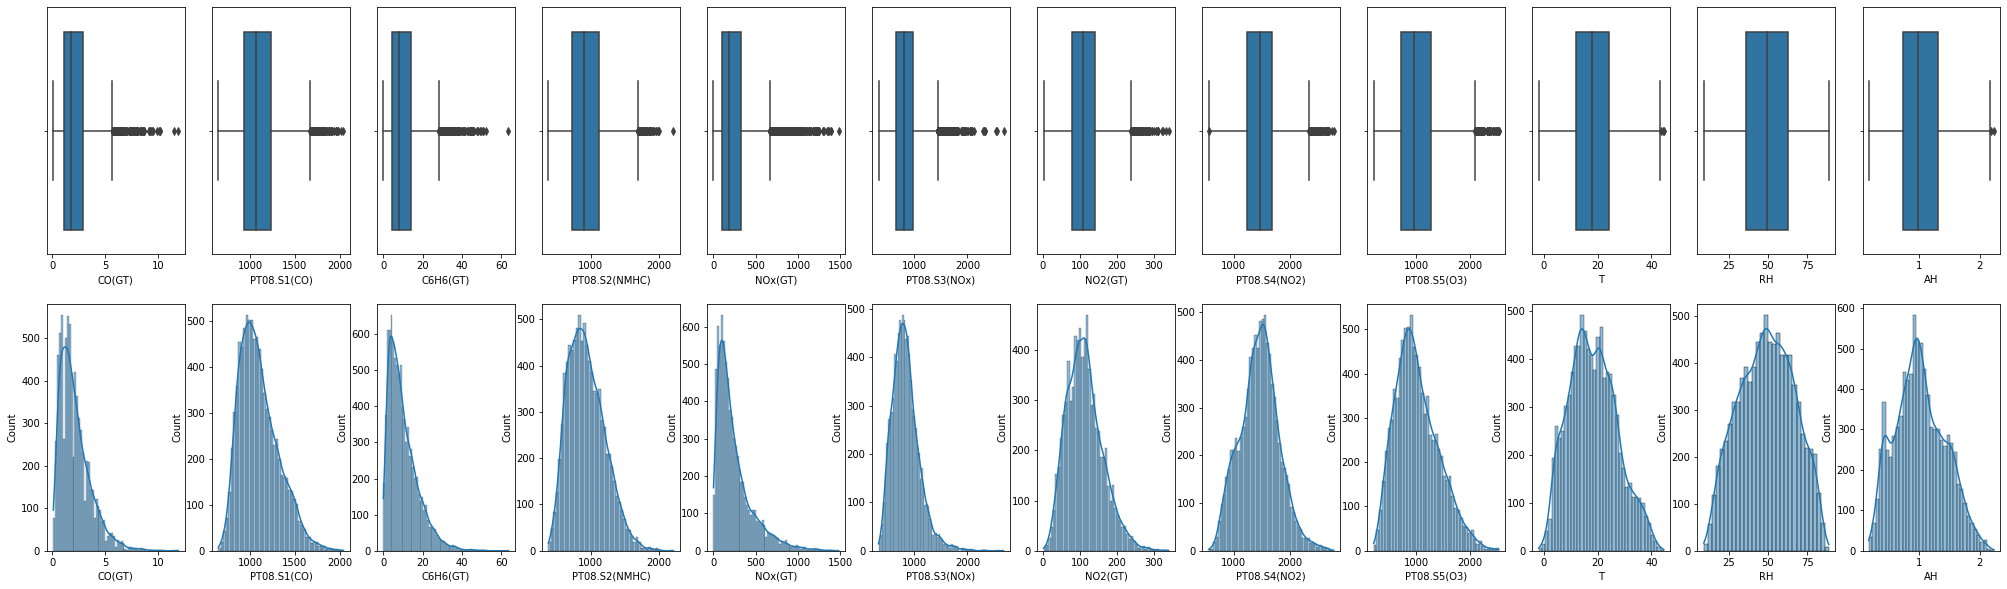

In [ ]:
fig, ax = plt.subplots(2,12,figsize=(35,10))
for i,c in enumerate(df.columns[:12]):
    sns.boxplot(x=df[c],ax=ax[0,i])
    sns.histplot(x=df[c],ax=ax[1,i],kde=True)
fig.show()

Most values seem to be normally distributed with some right skewing in some. imputation with mean or median should work well enough for those, maybe a bit less in the CO, C6H6, and NOx, let's see how well the model will perform with that little bit of bias in it

In [ ]:
imputer = SimpleImputer(strategy='median')

In [ ]:
imputer.fit(df)

SimpleImputer(strategy='median')

In [ ]:
imputed_df = pd.DataFrame(imputer.transform(df), columns=df.columns)

In [ ]:
x = imputed_df['CO(GT)']
y = imputed_df['NOx(GT)']
x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x]

# Baseline model and gradient descent

In [ ]:
m = y.size
alpha = 0.0005 #Step size
iterations = 20000 #No. of iterations
np.random.seed(21) #Set the seed
theta = np.random.rand(2) #Pick some random values to start with



def gradient_descent(x, y, theta, iterations, alpha):
    past_costs = []
    past_thetas = [theta]
    
    for i in range(iterations):
        prediction = np.dot(x, theta)
        error = prediction - y
        cost = 1/(2*m) * np.dot(error.T, error)
        past_costs.append(cost)
        theta = theta - (alpha * (1/m) * np.dot(x.T, error))
        past_thetas.append(theta)
        
    return past_thetas, past_costs


past_thetas, past_costs = gradient_descent(x, y, theta, iterations, alpha)
theta = past_thetas[-1]


print("Gradient Descent: {:.2f}, {:.2f}".format(theta[0], theta[1]))


Gradient Descent: 235.17, 152.25


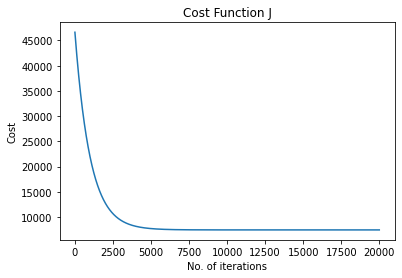

In [ ]:
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs)
plt.show()

In [ ]:
train = imputed_df.loc[imputed_df['PT08.S3(NOx)'].notnull()]
test = imputed_df.loc[imputed_df['PT08.S3(NOx)'].isnull()]

In [ ]:
TARGET = 'PT08.S3(NOx)'
NUMERICAL = df.select_dtypes(exclude=['category', 'object']).columns.tolist()
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [ ]:
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
         {'class': SimpleImputer, 'strategy': 'median'},
         {'class': StandardScaler}
    ]
)

In [ ]:
mapper = DataFrameMapper(numerical_def)
len(numerical_def)

11

In [ ]:
target = train[TARGET].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train.drop(TARGET, axis=1), target, test_size=0.3, random_state=2137, shuffle=True)

In [ ]:
x_train.shape, x_test.shape, train.shape

((6549, 11), (2808, 11), (9357, 12))

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
model.score(x_test, y_test)

0.8265542675773428

In [ ]:
train_x_tr = pd.DataFrame(mapper.fit_transform(x_train))
test_x_tr = pd.DataFrame(mapper.transform(x_test))

train_y_tr = pd.Series(np.log(y_train))
test_y_tr = pd.Series(np.log(y_test))

In [ ]:
model.fit(train_x_tr, train_y_tr)
print(f'\nR2 Test Score: {model.score(test_x_tr, test_y_tr)}')


R2 Test Score: 0.8778420158777596


In [ ]:
print(f'\nR2 Train Score: {model.score(train_x_tr, train_y_tr)}')


R2 Train Score: 0.8723613458092193


The R2 Test and Train scores are very similar and quite high. With 1 being perfect fit between the test and training set, a value of 0.87 suggests that we are able to explain a significant amount of variance in the data.

I did another run where i imputed the data using previous neighbour and surprisingly enough it returned almost idenitcal R2 scores - also 087xxx. In light of the missing data anlysis above though i decided to go with median imputing as it should introduce less bias.

In [ ]:
MAE= metrics.mean_absolute_error(y_test, y_pred)
MSE= metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(MSE)

pd.DataFrame([MAE, MSE, RMSE], index=['MAE', 'MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MAE,64.613946
MSE,11023.843619
RMSE,104.994493


Seems that the linear regression model was able to fit the data quite well, however there is still room for improvement as far as the errors go. It does perform better than any other imputation strategy or dropping more data i've tried.

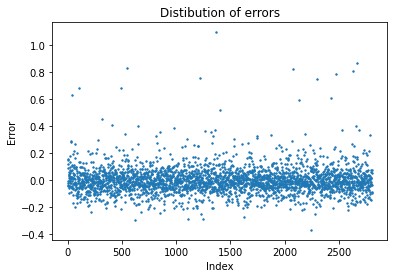

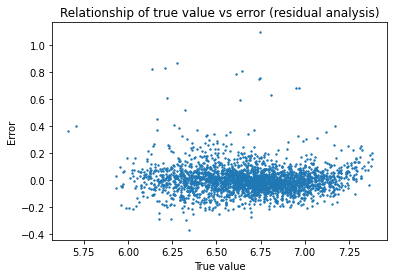

In [ ]:
pred = model.predict(test_x_tr)
errors = test_y_tr - pred

plt.scatter(list(range(len(errors))),errors, s = 2);
plt.title("Distibution of errors")
plt.ylabel('Error');
plt.xlabel('Index');
plt.show();

plt.scatter(pred,errors, s = 2);
plt.title('Relationship of true value vs error (residual analysis)')
plt.ylabel('Error');
plt.xlabel('True value');
plt.show();

Looking at the distribution of errors it seems that the erros are randomly distributed  around zero, so the model is a good fit for the data.

There seems to be some outliers with higher positive error values in the residual analysis, but other than a few outliers (that might as well result from the imputed data points) it seems that there is no distinct pattern so the model is a good fir

# Evaluation

In [ ]:
def evaluate_model(train, test, tr_y, tst_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_test = pipeline.predict(test)
    pred_train = pipeline.predict(train)
    mapper = pipeline.named_steps['mapper']

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'test_RMSE': [np.sqrt(mean_squared_error(tst_y, pred_test))],
        'test_R2': [r2_score(tst_y, pred_test)]
    }), mapper.transformed_names_

In [ ]:
pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', LinearRegression())
])

In [ ]:
scores, _ = evaluate_model(x_train, x_test, train_y_tr, test_y_tr, pipeline)
scores

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.104286,0.872361,0.102244,0.877842


Analysis with removed features. Selecting only features that correlate with 'NMHC(GT)' with correlation coefficient higher than 0.6

In [ ]:
ind = np.abs(train.corr()[TARGET]) > 0.5
top_corr = train.corr()[TARGET][ind].index.tolist()
top_corr.remove(TARGET)

In [ ]:
top_corr

['CO(GT)',
 'PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)']

In [ ]:
top_corr_features = [f for f in numerical_def if f[0][0] in top_corr]
pipeline = Pipeline([
    ('mapper', DataFrameMapper(top_corr_features)),
    ('estimator', LinearRegression())
])

In [ ]:
scores, colnames = evaluate_model(x_train, x_test, train_y_tr, test_y_tr, pipeline)
scores

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.128095,0.807426,0.127562,0.809854


looks like we actually got smaller R2 values with higher RMSE. Which mean the model that only considered the higher correlating variables performed poorer and with more error.

In [ ]:
def rmse(y_gt, Y_pr):
    return np.sqrt(mean_squared_error(y_gt, Y_pr))

print('RMSE Test: ')
print(rmse(test_y_tr, model.predict(test_x_tr)))
print('-'*10)

rmse_scorer = metrics.make_scorer(rmse)
print('RMSE cross-validation scores:')
CV_score = cross_val_score(model, train_x_tr, train_y_tr, cv=5, scoring=rmse_scorer, )
print(CV_score)
print('-'*310)

print('RMSE average cross-validation scores:')
print(np.sum(CV_score)/5)
print('-'*10)

RMSE Test: 
0.10224384175913115
----------
RMSE cross-validation scores:
[0.09954934 0.09937915 0.11372303 0.10516097 0.10426858]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
RMSE average cross-validation scores:
0.10441621276295066
----------


The RMSE are quite low and it seems that the model is generalizing to unseen data quite well. 
The k-fold cross-validation  shows that the results are quite consistent and the model fits the data well.

# Regularization




In [ ]:
def plot_importance(est, colnames, top_n=20):
    importance = pd.DataFrame({
        'abs_weight': np.abs(est.coef_),
        'feature': colnames
    })
    imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
    sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');

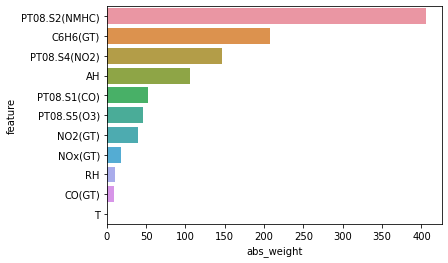

In [ ]:
lasso = Lasso() 
pipeline = Pipeline([('mapper', DataFrameMapper(numerical_def)), 
                     ('estimator', lasso)])

scores, colnames = evaluate_model(x_train, x_test, y_train, y_test, pipeline)
scores

plot_importance(pipeline.named_steps['estimator'], colnames)

Interestingly it seems that non-metalic hydro carbons and benzene (so another NMHC) are most important features in NOx predictions. Increasing the alpha parameter in Lasso function by even a little amplifies the absolute weight significantly. 



Surpisingly NO2 is only at 3rd place of importance predicting NOx values which might suggest which might suggest high concentratons of NO and N2O, the latter being especially interesting if high in concentration. 

Initially one might think that NO2 would strongly correlate enough to be the main predictor without putting in work into analysis. This is personally for me a very good example why one should try to avoid introducing bias of previous knowledge into analysis.

Correlation with NMHC suggests to me that the sensor might've been situated in a heavily industrialized area where nitrogen oxide emissions stem from atmospheric air being used in high temperature processes such as power generation or oil refining and not from things like fertilizers in farmlands or natural causes. Especially N20 would point towards gasification or combustion with less-than-optimal lambda air coefficients (not enough oxygen) or un-orthodox coal combustion plants that cause air to circulate in high temperature for a long time (fluidized bed boilers). We don't have that knowledge however so it would be safer to assume higher NO content (as would usually be the case with, say a lot of cars on the street being the cause).

The description of the data set did not specify directly which italian town the data was collected near but the fact alone that the focus of the orignal study was benzene (which, let's face it, emissions of it is not something one would usually be worried about) I bet that this was collected near Torino, or other highly-industrialized region with oil refinery or  natural-gas-heavy industry nearby.

# Tuning hyperparameters

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
pipeline = Pipeline([
    ('mapper', DataFrameMapper(numerical_def)),
    ('estimator', ElasticNet(random_state=42))
])
grid = {
    'estimator__alpha': np.linspace(0.01, 300, 10),
    'estimator__l1_ratio': np.arange(0, 1.1, 0.1) 
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv)

with alpha starting at 0 the algorythm did not converge, I've decided to start with a small vlaue instead just to apply any regularization to the model. With alpha = 0 my understanding is that we're essentially applying no regularization but we might underfit the model.

In [ ]:
gs.fit(x_train, y_train);

In [ ]:
gs.best_params_

{'estimator__alpha': 0.01, 'estimator__l1_ratio': 1.0}

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);
scores, col = evaluate_model(x_train, x_test, train_y_tr, test_y_tr, pipeline)
scores

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.123828,0.820042,0.123025,0.823139


The errors are higher and R2 lower than the initial model which suggests that we did not improve the performance here. Let's try Ridge estimator instead of ElasticNet and try a logarythmic distribution of alphas

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
pipeline = Pipeline([
    ('mapper', DataFrameMapper(numerical_def)),
    ('estimator', Ridge(random_state=42))
])
grid = {
    'estimator__alpha': np.logspace(-3, 2, num=100),
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv)

In [ ]:
gs.fit(x_train, y_train);

In [ ]:
gs.best_params_

{'estimator__alpha': 0.1668100537200059}

Alpha is small which means that not a lot of regularization is applied to the model and the model coefficients can take larger values. It might be prone to overfitting because of this. We did not lose a lot of complexity from a model

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);
scores, col = evaluate_model(x_train, x_test, train_y_tr, test_y_tr, pipeline)
scores

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.104286,0.872361,0.102244,0.877842


this are essentialy the values which we've obtained from the original model